`antman`

In [2]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pysam
import re
import os
import subprocess
import seaborn as sns
import sys
from PIL import Image
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
import warnings 
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import ranksums
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

Initializing transcriptomics package
Initializing plotting package


In [3]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_chr = list(set([gene.chromosome for gene in all_genes]))
lncRNAs = [tr.get_gene(gene) for gene in list(tr.genes.keys()) if tr.get_gene(gene).transcript_biotype == 'lnc_RNA']
len(lncRNAs), len(all_genes), len(all_chr)

(1424, 13810, 14)

In [4]:
def overlapping(chr1, start1, end1, chr2, start2, end2, min_overlap=0): 
    """ Returns true if the two regions overlap by at least min_overlap bases """
    # Check if the two regions are on the same chromosome
    if chr1 != chr2: 
        return False
    # Check if the two regions overlap by at least min_overlap bases
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= min_overlap

In [5]:
for i, row in tqdm(or_db.iterrows(), total=len(or_db)):
    gene = tr.get_gene(row['gene_name']) 
    if len(gene.transcripts) == 0: 
        continue 
    gene = gene.get_transcript_longest_cds()
    or_db.at[i, 'start'] = gene.get_bounds()[0]
    or_db.at[i, 'end'] = gene.get_bounds()[1]
    or_db.at[i, 'strand'] = gene.strand
    or_db.at[i, 'chr'] = gene.chromosome
    or_db.at[i, 'length'] = len(gene.dna_sequence)
    for lncRNA in lncRNAs: 
        if len(lncRNA.transcripts) == 0: 
            continue
        if lncRNA.chromosome != gene.chromosome: 
            continue
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        if overlapping(gene.chromosome, gene.get_bounds()[0], gene.get_bounds()[1], lncRNA.chromosome, lnc_start, lnc_end, min_overlap=5):
            or_db.at[i, 'overlapping_lnc'] = True 
            or_db.at[i, 'lnc_name'] = lncRNA.name 
            break

# Fill overlapping_lnc with False for genes that do not overlap with any lncRNA
or_db['overlapping_lnc'] = or_db['overlapping_lnc'].fillna(False)
or_db = or_db.dropna(subset=['start', 'end', 'strand', 'chromosome', 'length'])
# Exclude gene_name contains "Orco" or frag
or_db = or_db[~or_db['gene_name'].str.contains('Orco')]
or_db = or_db[~or_db['gene_name'].str.contains('frag')]
or_db = or_db.sort_values(by=['chromosome', 'end'])
or_db

100%|██████████| 502/502 [00:08<00:00, 60.17it/s] 


,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length,overlapping_lnc,lnc_name
0,1,Or5-R2,70,1,3',6504395.0,6510987.0,-,Chr1,6593.0,False,NaN
1,1,Or5-Q1,70,2,5',6511625.0,6514800.0,-,Chr1,3176.0,False,NaN
3,1,Or5-Q2,72,4,NaN,10934666.0,10938750.0,+,Chr1,4085.0,False,NaN
4,1,Or5-9E1,73,5,NaN,10980671.0,10984094.0,+,Chr1,3424.0,False,NaN
5,1,Or5-D1,75,6,NaN,16103937.0,16106542.0,-,Chr1,2606.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
496,12,Or5-L34,3,497,NaN,8805040.0,8807434.0,+,Chr12,2395.0,False,NaN
497,12,Or5-L35,3,498,3',8808087.0,8810716.0,+,Chr12,2630.0,False,NaN
498,12,Or5-9E350,5,499,NaN,12304526.0,12308947.0,+,Chr12,4422.0,False,NaN
499,12,Or5-9E351,6,500,NaN,13227042.0,13237610.0,-,Chr12,10569.0,False,NaN


In [6]:
antisense_ORs = or_db.loc[or_db['overlapping_lnc'] == False].reset_index(drop=True)
# Drop overlapping_lnc and lnc_name columns
antisense_ORs = antisense_ORs.drop(columns=['overlapping_lnc', 'lnc_name'])
# Change strand to opposite
antisense_ORs['strand'] = antisense_ORs['strand'].apply(lambda x: '+' if x == '-' else '-')
antisense_ORs


,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length
0,1,Or5-R2,70,1,3',6504395.0,6510987.0,+,Chr1,6593.0
1,1,Or5-Q1,70,2,5',6511625.0,6514800.0,+,Chr1,3176.0
2,1,Or5-Q2,72,4,NaN,10934666.0,10938750.0,-,Chr1,4085.0
3,1,Or5-9E1,73,5,NaN,10980671.0,10984094.0,-,Chr1,3424.0
4,1,Or5-D1,75,6,NaN,16103937.0,16106542.0,+,Chr1,2606.0
...,...,...,...,...,...,...,...,...,...,...
355,12,Or5-L34,3,497,NaN,8805040.0,8807434.0,-,Chr12,2395.0
356,12,Or5-L35,3,498,3',8808087.0,8810716.0,-,Chr12,2630.0
357,12,Or5-9E350,5,499,NaN,12304526.0,12308947.0,-,Chr12,4422.0
358,12,Or5-9E351,6,500,NaN,13227042.0,13237610.0,+,Chr12,10569.0


In [7]:
# Find nested lncRNAs within TAs 
TAs = or_db['tandem_array'].unique()
nested_lncRNAs = [] 

for ta_ in TAs: 
    TA_genes = or_db.loc[or_db['tandem_array'] == int(ta_)]
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    TA_strand = TA_genes['strand'].value_counts().index[0]
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    
    for lncRNA in lncRNAs: 
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        lnc_strand = lncRNA.strand 
        if lnc_start >= TA_bounds[0] and lnc_end <= TA_bounds[1] and lncRNA.chromosome == TA_chromosome and lncRNA.strand != TA_strand: 
            lnc_size = lnc_end - lnc_start
            nested_lncRNAs.append({
                'gene_name': lncRNA.name, 
                'tandem_array': ta_, 
                'start': lnc_start, 
                'end': lnc_end,
                'strand': lnc_strand,
                'chr': lncRNA.chromosome,
                'chromosome': int(lncRNA.chromosome.split('r')[1]),
                'length': lnc_size})

nested_lncRNAs = pd.DataFrame(nested_lncRNAs)
nested_lncRNAs

,gene_name,tandem_array,start,end,strand,chr,chromosome,length
0,LOC113562279,80,18415710,18417312,+,Chr1,1,1602
1,LOC105281803,56,2477097,2480203,+,Chr2,2,3106
2,LOC109611010,62,16521651,16522364,+,Chr2,2,713
3,LOC109611013,62,16482234,16482788,+,Chr2,2,554
4,LOC109611014,62,16511990,16513309,+,Chr2,2,1319
...,...,...,...,...,...,...,...,...
67,LOC105275250,10,12237414,12237785,-,Chr11,11,371
68,LOC105281874,3,8736692,8736982,-,Chr12,12,290
69,LOC105284280,3,8697329,8699194,-,Chr12,12,1865
70,LOC109611157,3,8807488,8808023,-,Chr12,12,535


In [8]:
antisense_regions = pd.concat([antisense_ORs, nested_lncRNAs]).reset_index(drop=True)
antisense_regions['annotation'] = antisense_regions['gene_name'].apply(lambda x: 'OR' if 'Or' in x else 'lncRNA')
antisense_regions

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length,annotation
0,1,Or5-R2,70,1.0,3',6504395.0,6510987.0,+,Chr1,6593.0,OR
1,1,Or5-Q1,70,2.0,5',6511625.0,6514800.0,+,Chr1,3176.0,OR
2,1,Or5-Q2,72,4.0,NaN,10934666.0,10938750.0,-,Chr1,4085.0,OR
3,1,Or5-9E1,73,5.0,NaN,10980671.0,10984094.0,-,Chr1,3424.0,OR
4,1,Or5-D1,75,6.0,NaN,16103937.0,16106542.0,+,Chr1,2606.0,OR
...,...,...,...,...,...,...,...,...,...,...,...
427,11,LOC105275250,10,NaN,NaN,12237414.0,12237785.0,-,Chr11,371.0,lncRNA
428,12,LOC105281874,3,NaN,NaN,8736692.0,8736982.0,-,Chr12,290.0,lncRNA
429,12,LOC105284280,3,NaN,NaN,8697329.0,8699194.0,-,Chr12,1865.0,lncRNA
430,12,LOC109611157,3,NaN,NaN,8807488.0,8808023.0,-,Chr12,535.0,lncRNA


In [9]:
def get_coverage_rRNA_depleted(tissue, orientation, chrom, start, end): 
    base_path = '../first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{tissue}_renamed_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


In [10]:
tissue = 'Pupae_S5'
for i, row in tqdm(antisense_regions.iterrows(), total=len(antisense_regions)): 
    # Get the coverage values for the region
    orientation = 'fwd' if row['strand'] == '+' else 'rev'
    coverage = get_coverage_rRNA_depleted(tissue, orientation, row['chr'], int(row['start']), int(row['end']))
    # Save the coverage values
    antisense_regions.at[i, 'coverage'] = coverage.mean() 

100%|██████████| 432/432 [00:37<00:00, 11.66it/s]


In [11]:
tissue = 'Pupae_S5'
for i, row in tqdm(antisense_regions.iterrows(), total=len(antisense_regions)): 
    # Get the coverage values for the antisense region 
    orientation = 'rev' if row['strand'] == '+' else 'fwd'
    coverage = get_coverage_rRNA_depleted(tissue, orientation, row['chr'], int(row['start']), int(row['end']))
    antisense_regions.at[i, 'coverage_anti'] = coverage.mean() 

100%|██████████| 432/432 [00:38<00:00, 11.11it/s]


In [12]:
antisense_regions

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length,annotation,coverage,coverage_anti
0,1,Or5-R2,70,1.0,3',6504395.0,6510987.0,+,Chr1,6593.0,OR,0.840109,2.650182
1,1,Or5-Q1,70,2.0,5',6511625.0,6514800.0,+,Chr1,3176.0,OR,0.095118,0.744252
2,1,Or5-Q2,72,4.0,NaN,10934666.0,10938750.0,-,Chr1,4085.0,OR,0.073947,0.725759
3,1,Or5-9E1,73,5.0,NaN,10980671.0,10984094.0,-,Chr1,3424.0,OR,52.155127,5.339176
4,1,Or5-D1,75,6.0,NaN,16103937.0,16106542.0,+,Chr1,2606.0,OR,1.072553,3.620345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,11,LOC105275250,10,NaN,NaN,12237414.0,12237785.0,-,Chr11,371.0,lncRNA,2.932615,2.385445
428,12,LOC105281874,3,NaN,NaN,8736692.0,8736982.0,-,Chr12,290.0,lncRNA,4.644828,3.524138
429,12,LOC105284280,3,NaN,NaN,8697329.0,8699194.0,-,Chr12,1865.0,lncRNA,2.228954,0.323861
430,12,LOC109611157,3,NaN,NaN,8807488.0,8808023.0,-,Chr12,535.0,lncRNA,2.342056,3.786916


In [13]:
# Relative coverage
antisense_regions['relative_coverage'] = antisense_regions['coverage'] / antisense_regions['coverage_anti'] 
antisense_regions

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length,annotation,coverage,coverage_anti,relative_coverage
0,1,Or5-R2,70,1.0,3',6504395.0,6510987.0,+,Chr1,6593.0,OR,0.840109,2.650182,0.317001
1,1,Or5-Q1,70,2.0,5',6511625.0,6514800.0,+,Chr1,3176.0,OR,0.095118,0.744252,0.127804
2,1,Or5-Q2,72,4.0,NaN,10934666.0,10938750.0,-,Chr1,4085.0,OR,0.073947,0.725759,0.101889
3,1,Or5-9E1,73,5.0,NaN,10980671.0,10984094.0,-,Chr1,3424.0,OR,52.155127,5.339176,9.768385
4,1,Or5-D1,75,6.0,NaN,16103937.0,16106542.0,+,Chr1,2606.0,OR,1.072553,3.620345,0.296257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,11,LOC105275250,10,NaN,NaN,12237414.0,12237785.0,-,Chr11,371.0,lncRNA,2.932615,2.385445,1.229379
428,12,LOC105281874,3,NaN,NaN,8736692.0,8736982.0,-,Chr12,290.0,lncRNA,4.644828,3.524138,1.318004
429,12,LOC105284280,3,NaN,NaN,8697329.0,8699194.0,-,Chr12,1865.0,lncRNA,2.228954,0.323861,6.882450
430,12,LOC109611157,3,NaN,NaN,8807488.0,8808023.0,-,Chr12,535.0,lncRNA,2.342056,3.786916,0.618460


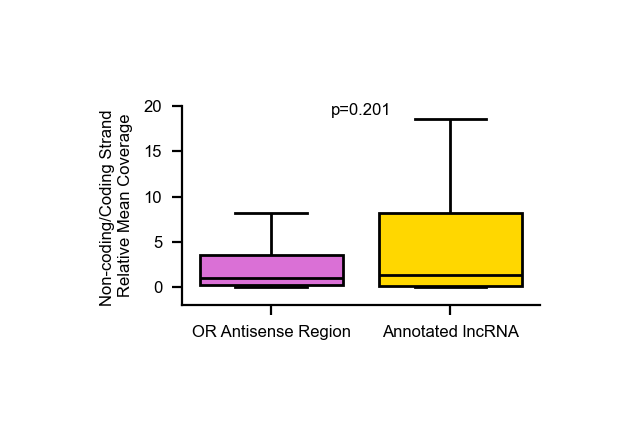

In [19]:
# Plot exon_opp_rel_Pupae_S5 split by overlapping_lncRNA
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5), dpi = 200)
sns.boxplot(data=antisense_regions, 
            y='relative_coverage', 
            x='annotation', 
            palette=['orchid', 'gold'], 
            linecolor='black',
            linewidth=1,
            fliersize=0,
            saturation = 1, 
            ax=ax, 
            order=["OR", "lncRNA"])

plt.ylim(-2, 20)
plt.yticks(range(0, 21, 5), fontsize=6)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([0, 1], ['OR Antisense Region', 'Annotated lncRNA'], fontsize=6)
plt.ylabel('Non-coding/Coding Strand \nRelative Mean Coverage', fontsize=6)
plt.xlabel('')


# Calculate p-value 
unannotated = antisense_regions[antisense_regions['annotation'] == 'OR']['relative_coverage'].dropna()
annotated = antisense_regions[antisense_regions['annotation'] == 'lncRNA']['relative_coverage'].dropna()
p = ranksums(unannotated, annotated).pvalue

p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 19, p_value_str, ha='center', fontsize=6)

plt.tight_layout()
plt.savefig(f"../figures/uannotated-vs-annotated-lncrna-rRNA-depleted.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()